## Churn prediction analysis

In [ ]:
# The objective of this analysis is to predict whether bank clients are about to churn.

# We work with a labeled churn dataset with different clients metrics.

# We'll run first through data exploration, then modelling.

## Import Packages

In [209]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import scipy.stats

from scipy.stats import binned_statistic
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix, fbeta_score, make_scorer,\
classification_report, RocCurveDisplay, f1_score, precision_score, PrecisionRecallDisplay, accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.svm import SVC, LinearSVC
import xgboost as xgb

## Extract data

In [210]:
raw_data = pd.read_csv('dataset.csv', index_col=0 )

In [211]:
# Have a look at the dataset

# Credit score is based on five factors: payment history, amount owed, length of credit history, new credit, and credit mix
raw_data.head(5)

,CreditScore,Country,Gender,Age,Tenure,Balance,NumOfProducts,HasCreditCard,IsActiveMember,Salary,Churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [212]:
# Check size, duplicates

raw_data.shape

(9338, 11)

In [213]:
# No duplicates (technically two clients could have the same data but it's unlikely)

raw_data.copy().drop_duplicates().shape

(9338, 11)

In [214]:
# Get a sense of the distributions and potential outliers
# Note that salary has missing values

raw_data.describe().round()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCreditCard,IsActiveMember,Salary,Churn
count,9338.0,9338.0,9338.0,9338.0,9338.0,9338.0,9338.0,8404.0,9338.0
mean,651.0,39.0,5.0,75508.0,2.0,1.0,1.0,99917.0,0.0
std,96.0,10.0,3.0,62553.0,1.0,0.0,0.0,57460.0,0.0
min,350.0,18.0,0.0,0.0,1.0,0.0,0.0,12.0,0.0
25%,584.0,32.0,3.0,0.0,1.0,0.0,0.0,50908.0,0.0
50%,652.0,37.0,5.0,96040.0,2.0,1.0,1.0,99731.0,0.0
75%,718.0,43.0,7.0,127404.0,2.0,1.0,1.0,148858.0,0.0
max,850.0,92.0,10.0,250898.0,4.0,1.0,1.0,199992.0,1.0


In [215]:
# Get average churn rate in total

raw_data.Churn.mean().round(2)

0.15

## Plots

<Axes: xlabel='IsActiveMember', ylabel='Count'>

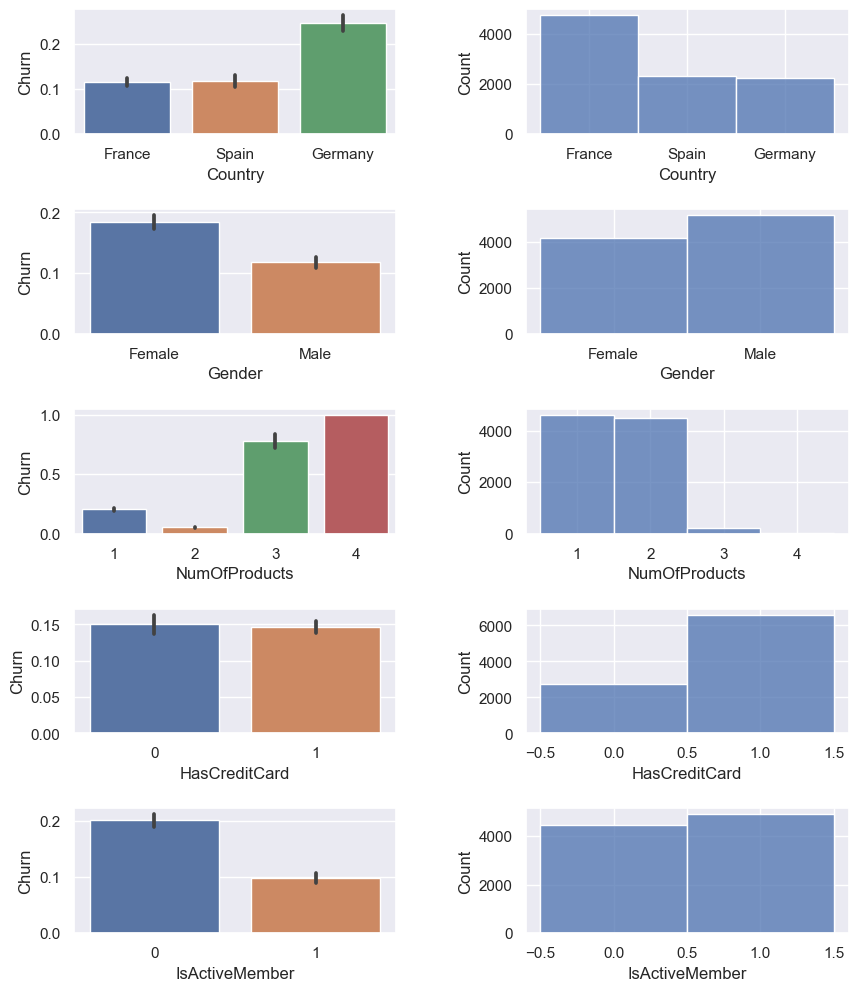

In [216]:
# Plot the average churn rate by categorical value

# We would turn the plotting into a function or do it on a data exploration/visualization tool such as Tableau

# Filtering the warnings in this cell because of a categorical variable warning
warnings.simplefilter("ignore")
sns.set(rc={'figure.figsize':(10,12)})

fig = plt.figure()

fig.subplots_adjust(hspace=0.6, wspace=0.4)

fig.add_subplot(5, 2, 1)
sns.barplot(data=raw_data, x="Country", y="Churn")

fig.add_subplot(5, 2, 2)
sns.histplot(data=raw_data, x="Country")

fig.add_subplot(5, 2, 3)
sns.barplot(data=raw_data, x="Gender", y="Churn")

fig.add_subplot(5, 2, 4)
sns.histplot(data=raw_data, x="Gender")

fig.add_subplot(5, 2, 5)
sns.barplot(data=raw_data, x="NumOfProducts", y="Churn")

fig.add_subplot(5, 2, 6)
sns.histplot(data=raw_data, x="NumOfProducts", discrete = True)

fig.add_subplot(5, 2, 7)
sns.barplot(data=raw_data, x="HasCreditCard", y="Churn")

fig.add_subplot(5, 2, 8)
sns.histplot(data=raw_data, x="HasCreditCard", discrete = True)

fig.add_subplot(5, 2, 9)
sns.barplot(data=raw_data, x="IsActiveMember", y="Churn")

fig.add_subplot(5, 2, 10)
sns.histplot(data=raw_data, x="IsActiveMember", discrete = True)

# Has credit card seem to have little effect
# Gender, country, active members seem to have the most impact
# Number of products has a positive influence up to 2 products, sample size beyond that is too small

<Axes: xlabel='Salary', ylabel='Count'>

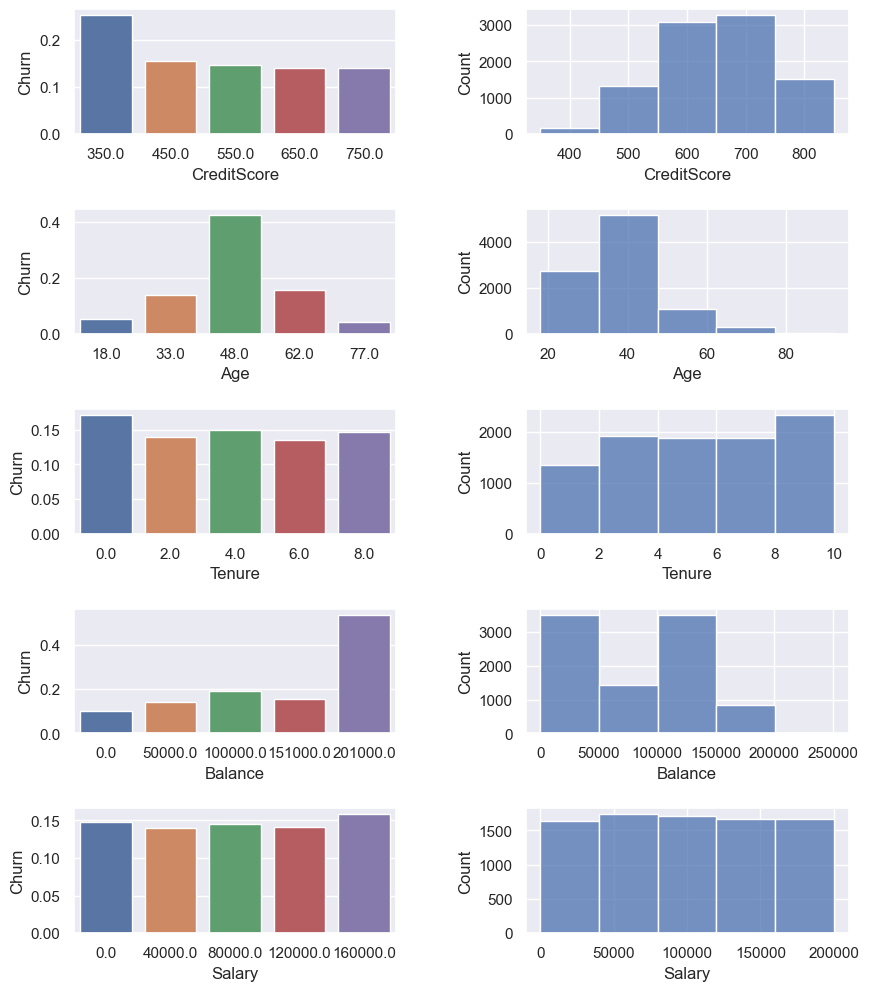

In [217]:
# Plot the average churn rate by continuous values

def bin_data(cont_variable, value, bins, round_val):
    data = raw_data.copy()[[cont_variable, value]].dropna()
    statistics, bin_edges, _ = binned_statistic(data[cont_variable], data[value], 
                                 statistic='mean', bins=5)
    
    df = pd.DataFrame({cont_variable: bin_edges.round(round_val)[:-1], value: statistics})
    plot = sns.barplot(data=df, x=cont_variable, y=value)
    
    return plot

fig2 = plt.figure()
fig2.subplots_adjust(hspace=0.6, wspace=0.4)

fig2.add_subplot(5, 2, 1)
bin_data("CreditScore", "Churn", 5, 0)

fig2.add_subplot(5, 2, 2)
sns.histplot(data=raw_data, x="CreditScore", bins=5)

fig2.add_subplot(5, 2, 3)
bin_data("Age", "Churn", 5, 0)

fig2.add_subplot(5, 2, 4)
sns.histplot(data=raw_data, x="Age", bins=5)

fig2.add_subplot(5, 2, 5)
bin_data("Tenure", "Churn", 5, 0)

fig2.add_subplot(5, 2, 6)
sns.histplot(data=raw_data, x="Tenure", bins=5)

fig2.add_subplot(5, 2, 7)
bin_data("Balance", "Churn", 5, -3)

fig2.add_subplot(5, 2, 8)
sns.histplot(data=raw_data, x="Balance", bins=5)

fig2.add_subplot(5, 2, 9)
bin_data("Salary", "Churn", 5, -3)

fig2.add_subplot(5, 2, 10)
sns.histplot(data=raw_data, x="Salary", bins=5)


# Low credit score, Age, and high account balance seem correlated with high churn 
# (the last one seems counter intuitive, could be a low sample)
# Salary seems to be inaccurate (flat distribution)

<Axes: >

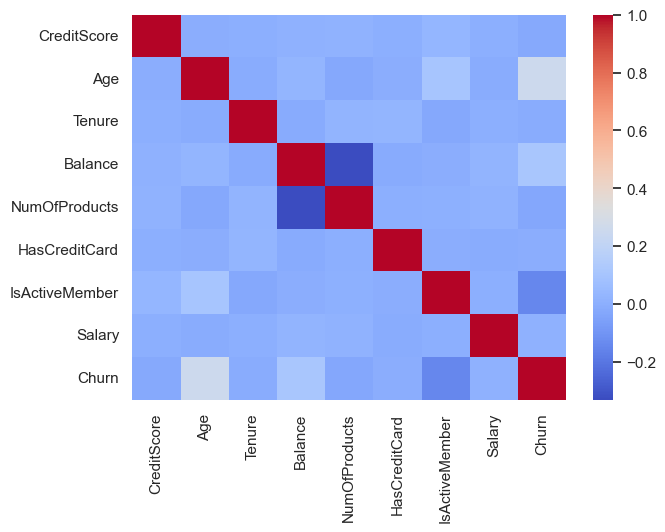

In [218]:
# Checking correlations between variables
sns.set(rc={'figure.figsize':(7,5)})

data_cont = raw_data[['CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCreditCard', 'IsActiveMember', 'Salary', 'Churn']]

sns.heatmap(data_cont.corr(),
                xticklabels=data_cont.columns,
                yticklabels=data_cont.columns,
                cmap = 'coolwarm')

# Churn seems to have a correlation with age, Balance, IsActiveMember
# Num of products is negatively correlated with Balance

## Creating New features

In [219]:
# A few questions based on the data that we have:

# Do clients with high salary and low balance use the bank as a secondary bank?
# Should we consider that accounts with balance 0 and no salary are churned?

In [248]:
# Checking accounts that have zero balance and not active : technically churned as well
# Inactive accounts with balance have the highest churn

raw_data['has_balance'] = raw_data['Balance'].apply(lambda x: 0 if x==0 else 1)

raw_data.groupby(['has_balance', 'IsActiveMember']).agg({'Churn': ['mean', 'count', 'sum']})

Churn           
                                mean count  sum
has_balance IsActiveMember                     
0           0               0.133820  1644  220
            1               0.062569  1806  113
1           0               0.240972  2797  674
            1               0.119055  3091  368

In [261]:
# Create a new features based on whether people are active and have balance
# We could argue that clients inactive with no balance should be labeled as churned.

def active_zero(row):
    if row.Balance>0 and row.IsActiveMember==0:
        res = 1
    else:
        res = 0
    return res
    
raw_data['inactive_with_balance'] = raw_data.apply(active_zero, axis=1)

In [ ]:
# Check if there's a relationship between clients inactive and clients with several products

In [250]:
raw_data.groupby(['NumOfProducts', 'IsActiveMember']).agg({'Churn': ['mean', 'count', 'sum']})

# We see that the churn rate is very high for clients with only 1 product and inactive

Churn           
                                  mean count  sum
NumOfProducts IsActiveMember                     
1             0               0.284498  2232  635
              1               0.128721  2385  307
2             0               0.065764  2068  136
              1               0.040299  2407   97
3             0               0.848739   119  101
              1               0.674419    86   58
4             0               1.000000    22   22
              1               1.000000    19   19

In [260]:
# Create the related feature

def active_zero(row):
    if row.NumOfProducts==1 and row.IsActiveMember==0:
        res = 1
    else:
        res = 0
    return res
    
raw_data['one_product_inactive'] = raw_data.apply(active_zero, axis=1)

In [258]:
# Check if there's a relationship between age and activity

bins = [18, 30, 40, 50, 60, 100]
raw_data['age_bin'] = pd.cut(raw_data['Age'], bins)
raw_data.groupby(['age_bin', 'IsActiveMember']).agg({'Churn': ['mean', 'count', 'sum']})

# We see that the churn rate for inactive members over 50 explodes

Churn           
                              mean count  sum
age_bin   IsActiveMember                     
(18, 30]  0               0.069565   920   64
          1               0.033777   977   33
(30, 40]  0               0.107880  2132  230
          1               0.058080  2135  124
(40, 50]  0               0.333333  1074  358
          1               0.184000  1000  184
(50, 60]  0               0.799163   239  191
          1               0.264059   409  108
(60, 100] 0               0.761194    67   51
          1               0.082645   363   30

In [284]:
# Create the related feature

raw_data.drop('age_bin', axis=1, inplace=True)

def active_zero(row):
    if row.Age>45 and row.IsActiveMember==0:
        res = 1
    else:
        res = 0
    return res
    
raw_data['over_45_inactive'] = raw_data.apply(active_zero, axis=1)

## Conclusion from the data exploration

Overall, the dataset is clean with a few outliers in balance (over 200k), 
age (over 60), Number of products (3 and more), and low credit score (under 400).

Depending on the model we use, we need to keep these into account and potentialy filter out outliers. 

- The variables that seem to have most impact on churn are : 

Age: churn peaks at age 50 
Is Active Member
Country (maybe a service issue?)
Gender : female churns twice as much

- Seconday variables are :

Number of products
Credit Score
Balance

- Additional data signals

Having additional signals such as a timeseries field here would be great, to measure time to churn.
As well as information about number of bank operations over the last period, 
contacts with the bank, mortages, the actual type of products they use (instead of number of products)

Also, we don't know when was the snapshot taken (how long before the churn date?)

We could also ask the bank to refine their classification:
Accounts with 0 balance, 0 salary are technically not bringing any value to the bank.
The churns that we care about most are the high salary, high balance customers. 

## Modelling

- We'll test logistic regression, SVC, random forests, and XGboost for our classification problem.
- We'll compare the models with recall and f2_score, since there is a class imbalance and that we care more about recall for churn use cases.

## Preprocessing the dataset

In [285]:
# Create a copy
data_model = raw_data.copy()

# Splitting the dataset in a train, validation and test set
y = data_model["Churn"].values

In [286]:
# One hot encoding

cols_cat = ['Country', 'Gender', 'NumOfProducts']

data_model = pd.get_dummies(data_model, prefix=cols_cat, prefix_sep='_', 
                          columns=cols_cat, dtype=int)

data_model.head()

,CreditScore,Age,Tenure,Balance,HasCreditCard,IsActiveMember,Salary,Churn,has_balance,over_45_inactive,...,inactive_with_balance,Country_France,Country_Germany,Country_Spain,Gender_Female,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,619,42,2,0.00,1,1,101348.88,1,0,0,...,0,1,0,0,1,0,1,0,0,0
1,608,41,1,83807.86,0,1,112542.58,0,1,0,...,0,0,0,1,1,0,1,0,0,0
2,502,42,8,159660.80,1,0,113931.57,1,1,0,...,1,1,0,0,1,0,0,0,1,0
3,699,39,1,0.00,0,0,93826.63,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,850,43,2,125510.82,1,1,79084.10,0,1,0,...,0,0,0,1,1,0,1,0,0,0


In [287]:
# Split out the test and train set
X_train, X_test, y_train, y_test = train_test_split(data_model, y, test_size = 0.2, random_state = 42) 

# Check the datasets
print(np.mean(y_train).round(2), np.mean(y_test).round(2))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

0.15 0.15


((7470, 21), (1868, 21), (7470,), (1868,))

In [288]:
X_train.drop('Churn', axis=1, inplace=True)
X_test.drop('Churn', axis=1, inplace=True)

In [289]:
# Sampling strategies
# Showed no clear improvement on the model

# X_train, y_train = SMOTE().fit_resample(X_train, y_train)
# X_train, y_train = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)

## Create Evaluation methods

In [290]:
# Define a function to evaluate our models: adding a f2 score

def get_metrics(model, name, X, y, print_=None):
    
    f1_s = f1_score(y, model.predict(X)).round(3)
    recall = recall_score(y, model.predict(X)).round(3)
    prec = precision_score(y, model.predict(X)).round(3)
    f2 = fbeta_score(y, model.predict(X), beta=2)
    accuracy = accuracy_score(y, model.predict(X)).round(3)
    class_rep = classification_report(y, model.predict(X))

    if print_=='print':
        print(f'Classification report: \n{class_rep}')
    
    return [name, f1_s, recall, prec, f2]

In [291]:
# Create a scorer for the models scoring parameters, where we place more importance on recall

ftwo_scorer = make_scorer(fbeta_score, beta=2)

In [292]:
# Create Kfold

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

In [293]:
# Feature Selection
# Showed no clear improvement on the model, nor did PCA

# fs = SelectKBest(score_func=f_classif, k=10)
# fs = SelectFromModel(LinearSVC(dual="auto", penalty="l1"))

In [294]:
# Initiate our summary table

metrics_df = pd.DataFrame(columns = ['model_name', 'f1_score', 'recall', 'precision', 'f2_score'])

In [295]:
# Create scaling pipeline steps for models that require scaling

steps_p = [("imp_mean", SimpleImputer(strategy='mean')),
           ("scaler", StandardScaler())]

preprocessor = Pipeline(steps_p)

## Logistic regression

In [296]:
# Set up pipeline
steps = [("preprocessor", preprocessor),
        ("logreg", LogisticRegression(class_weight='balanced', penalty='l2'))]

pipeline = Pipeline(steps)

# Create grid params
params = {"logreg__solver": ["newton-cg", "saga", "lbfgs"],
        "logreg__C": np.linspace(0.001, 1.0, 10)}

# Create the RandomizedSearchCV object
grid_lr = RandomizedSearchCV(pipeline, params, cv=kf, scoring=ftwo_scorer)
grid_lr.fit(X_train, y_train)

# Assign the best model
lr_clf = grid_lr.best_estimator_

# Compute and print performance
metrics_df.loc[len(metrics_df)] = get_metrics(grid_lr, 'Logistic Regression', X_test, y_test, 'print')

Classification report: 
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      1587
           1       0.39      0.74      0.51       281

    accuracy                           0.78      1868
   macro avg       0.67      0.77      0.68      1868
weighted avg       0.86      0.78      0.81      1868



## SVC

In [297]:
# Set up pipeline
steps = [("preprocessor", preprocessor),
        ("svc", SVC(probability=True, class_weight='balanced'))]

pipeline = Pipeline(steps)

# Create grid params
params = {"svc__gamma": ['auto', 'scale'],
          "svc__C": np.linspace(0.001, 1.0, 10),
          "svc__kernel": ['rbf', 'linear', 'poly', 'sigmoid']}

# Create the RandomizedSearchCV object
grid_svc = RandomizedSearchCV(pipeline, params, n_iter=5, cv=kf, scoring=ftwo_scorer)
grid_svc.fit(X_train, y_train)

# Assign the best model
svc_clf = grid_svc.best_estimator_

# Compute and print performance
metrics_df.loc[len(metrics_df)] = get_metrics(grid_svc, 'SVC', X_test, y_test, 'print')

Classification report: 
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      1587
           1       0.40      0.71      0.51       281

    accuracy                           0.80      1868
   macro avg       0.67      0.76      0.69      1868
weighted avg       0.86      0.80      0.82      1868



## Random Forest

In [298]:
# Set up pipeline
steps = [("imp_mean", SimpleImputer(strategy='mean')),
         ("rf", RandomForestClassifier())]

pipeline = Pipeline(steps)

# Create grid params
params = {'rf__n_estimators': np.arange(100, 1000, 100, dtype=int),
              'rf__max_features':['auto', 'sqrt'],
              'rf__max_depth': np.arange(1, 15, 1, dtype=int),
              'rf__max_samples': np.linspace(0.05, 1.0, 10),
              'rf__min_samples_split': np.arange(1, 10, 1, dtype=int),
              'rf__class_weight': ['balanced', None]}

# Create the RandomizedSearchCV object
grid_rf = RandomizedSearchCV(pipeline, 
                             params, 
                             n_iter=50, 
                             cv=kf,
                             scoring=ftwo_scorer)  
                             
grid_rf.fit(X_train, y_train)

# Assign the best model
rf_clf = grid_rf.best_estimator_
                             
# Compute and print performance
metrics_df.loc[len(metrics_df)] = get_metrics(grid_rf, 'Random Forest', X_test, y_test, 'print')

Classification report: 
              precision    recall  f1-score   support

           0       0.95      0.83      0.88      1587
           1       0.43      0.74      0.54       281

    accuracy                           0.81      1868
   macro avg       0.69      0.78      0.71      1868
weighted avg       0.87      0.81      0.83      1868



## XGBoost

In [299]:
# Set up pipeline
steps = [("imp_mean", SimpleImputer(strategy='mean')),
         ("xgb", xgb.XGBClassifier())]

pipeline = Pipeline(steps)

# Create grid params
params = {'xgb__n_estimators': np.arange(10, 200, 10, dtype=int),
          'xgb__learning_rate': np.linspace(0.01, 0.3, 20),
          'xgb__max_depth': np.arange(3, 15, 1, dtype=int),
          'xgb__min_child_weight': np.arange(1, 7, 1, dtype=int),
          'xgb__gamma': np.linspace(0.0, 0.4, 10),
          'xgb__colsample_bytree': np.linspace(0.3, 1, 10),
          'xgb__subsample': np.linspace(0.6, 1, 5),
          'xgb__lambda': np.arange(1, 5, 1, dtype=int),
          'xgb__alpha': np.arange(1, 5, 1, dtype=int),
         }

# Create the RandomizedSearchCV object
grid_xgb = RandomizedSearchCV(pipeline,
                             param_distributions=params,
                             n_iter=50,
                             cv=kf,
                             scoring=ftwo_scorer)

grid_xgb.fit(X_train, y_train)

# Assign the best model
xgb_clf = grid_xgb.best_estimator_

# Compute and print performance
metrics_df.loc[len(metrics_df)] = get_metrics(xgb_clf, 'XGB', X_test, y_test, 'print')

Classification report: 
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1587
           1       0.73      0.44      0.55       281

    accuracy                           0.89      1868
   macro avg       0.82      0.71      0.75      1868
weighted avg       0.88      0.89      0.88      1868



## Plotting ROC and Precision/Recall Curves

<Figure size 700x500 with 0 Axes>

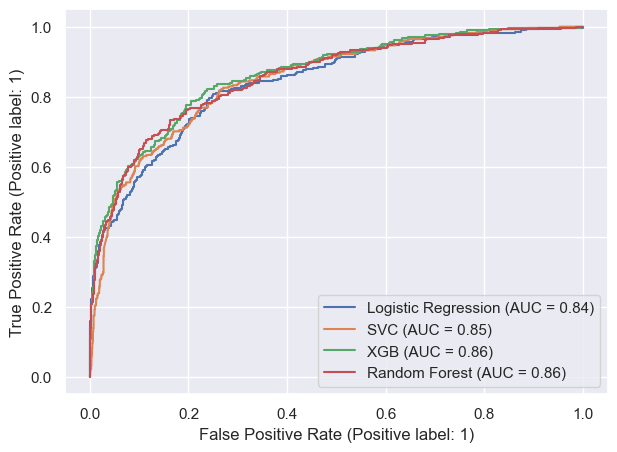

In [300]:
# Since there is a class imbalance, it is hard to draw conclusions from ROC AUC
# Hence we plot precision-recall below

fig2 = plt.figure()

lr_disp = RocCurveDisplay.from_estimator(grid_lr, X_test, y_test, name='Logistic Regression') 
svc_disp = RocCurveDisplay.from_estimator(grid_svc, X_test, y_test, ax=lr_disp.ax_, name='SVC') 
xgb_disp = RocCurveDisplay.from_estimator(grid_xgb, X_test, y_test, ax=lr_disp.ax_, name='XGB') 
rf_disp = RocCurveDisplay.from_estimator(grid_rf, X_test, y_test, ax=lr_disp.ax_, name='Random Forest') 

<Figure size 700x500 with 0 Axes>

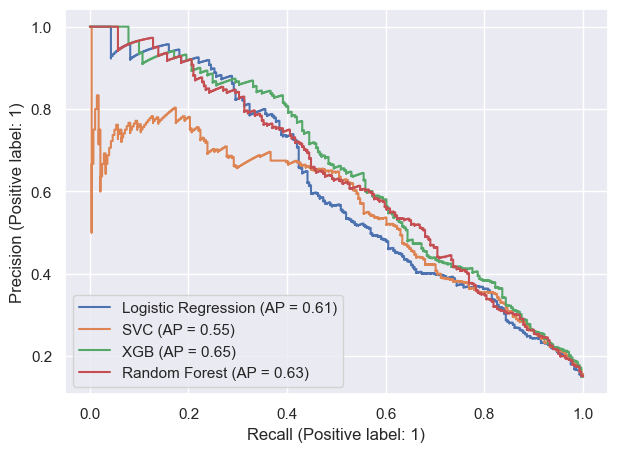

In [301]:
fig2 = plt.figure()

lr_disp = PrecisionRecallDisplay.from_estimator(grid_lr, X_test, y_test, name='Logistic Regression') 
svc_disp = PrecisionRecallDisplay.from_estimator(grid_svc, X_test, y_test, ax=lr_disp.ax_, name='SVC') 
xgb_disp = PrecisionRecallDisplay.from_estimator(grid_xgb, X_test, y_test, ax=lr_disp.ax_, name='XGB') 
rf_disp = PrecisionRecallDisplay.from_estimator(grid_rf, X_test, y_test, ax=lr_disp.ax_, name='Random Forest') 

In [302]:
# Look at model with best metrics on test set
# f2 score is relevant for imbalanced datasets where recall matters, like churn
# Precision remains relatively low when optimizing for f2 score

metrics_df_test = pd.DataFrame(columns = ['model_name', 'f1_score', 'recall', 'precision', 'f2 score'])

print(metrics_df)

            model_name  f1_score  recall  precision  f2_score
0  Logistic Regression     0.507   0.740      0.385  0.625000
1                  SVC     0.512   0.712      0.400  0.615764
2        Random Forest     0.541   0.737      0.428  0.643657
3                  XGB     0.552   0.445      0.727  0.482253


## Exploring the best model

The highest performing model on the test set is Random Forest with the best balance between precision and recall.

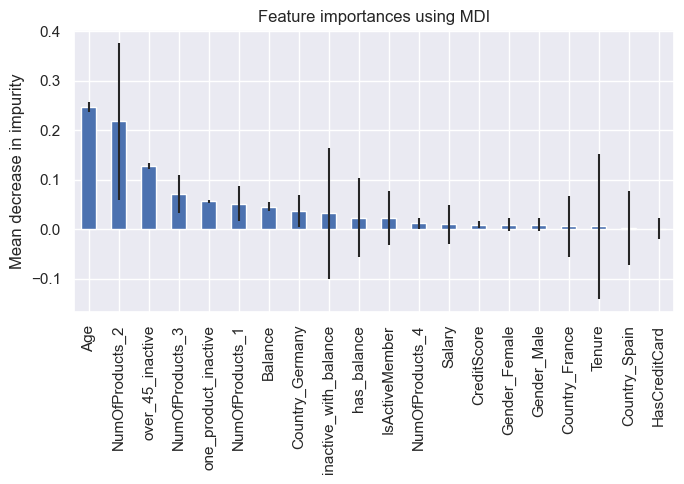

In [303]:
feature_names = X_train.columns
importances = rf_clf.steps[1][1].feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.steps[1][1].estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()